# MOOC Analysis

This notebook conducts analysis on the trends of online learning through MOOC platforms with respect to developer trends at different skill levels

| Date | User | Change Type | Remarks |  
| ---- | ---- | ----------- | ------- |
| 05/30/2025   | Martin | Create  | Notebook for analysis of MOOC data. Started visual summary of dataframe | 

# Content

* [Introduction](#introduction)
* [Data](#data)
* [Summary Breakdown](#summary-breakdown)

# Introduction

The journey of a develop and data scientist is a never-ending thirst for new knowledge and upskilling. As new technologies are constantly being created, the onus is on us to continually update ourselves with new and relevant skills that are used within the industry. The rise of MOOC platforms has made picking up these skills much easier compared to the past. Courses cover a wide variety of topics from general overviews of a tool, to projects that aim to impart very specific skills.

The consensus in the community is that there are some fundamentals that should be developed before moving on to more advanced concepts. As such, the focus of this analysis is to identify the different trends related to the skills required at each level. We also compare this to the general programming community to see if the courses and projects offered by MOOC platforms are congruent with the skills in-demand by existing developers and data scientists

# Data

We are using the `combined_mooc.csv` and the (INSERT STACKOVERFLOW DATASET) as our primary dataframes to conduct this analysis

<u>Key points on MOOC dataset</u>
* 3 levels of skill encoded (Beginner, Intermediate, Advanced)

In [1]:
import ast

import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Load MOOC data - some values are stored as lists and need to be converted back
df_mooc = pd.read_csv('combined_mooc.csv', low_memory=False)

cols_to_convert = ['skills', 'reviews', 'subject', 'reviews_comments', 'reviews_stars']
for col in cols_to_convert:
  df_mooc[col] = df_mooc[col].apply(lambda x: ast.literal_eval(x) if not pd.isna(x) else x)

In [3]:
df_mooc.head()

,type,course_name,organization,rating,description,skills,level,duration,reviews,enrollments,subject,provider,language,reviews_comments,reviews_stars,reviews_avg_stars,num_reviews,premium
0,course,AWS Lambda إنشاء صورة مصغرة بإستخدام السيرفرل...,Coursera Project Network,NaN,هذا المشروع التفاعلي -إنشاء صورة مصغرة بإستخدا...,"[AWS Identity And Access Management (IAM), Clo...",Intermediate,2.0,NaN,NaN,NaN,coursera,ar,NaN,NaN,NaN,NaN,NaN
1,course,Assisting Public Sector Decision Makers With ...,University of Michigan,4.8,Develop data analysis skills that support publ...,"[Simulations, Statistical Analysis, Predictive...",Intermediate,16.0,[{'comment': 'This course was very good at get...,NaN,NaN,coursera,en,[wonderful],[5],5.0,1.0,NaN
2,course,Advanced Strategies for Sustainable Business,University of Colorado Boulder,NaN,This course focuses on integrating sustainabil...,"[Circular Economy, Sustainable Business, Stake...",Beginner,6.0,NaN,NaN,NaN,coursera,en,NaN,NaN,NaN,NaN,NaN
3,course,Applying Machine Learning to Your Data with G...,Google Cloud,NaN,"Dans ce cours, nous définirons ce qu'est le ma...",NaN,Beginner,10.0,NaN,NaN,NaN,coursera,fr,NaN,NaN,NaN,NaN,NaN
4,project,Automate Blog Advertisements with Zapier,Coursera Project Network,NaN,Zapier is the industry leader in task automati...,"[Advertising, Social Media, Blogging, Marketing]",Intermediate,2.0,"[{'comment': 'wonderful', 'stars': 5}]",NaN,NaN,coursera,en,"[Very good way of teaching., Good, Good]","[5, 5, 5]",5.0,3.0,NaN


# Summary Breakdown

First we create a breakdown for some columns and derive some basic insights about the MOOC dataset

In [43]:
# Data processing to generate plots
count_type = df_mooc['type'].value_counts()
count_type = pd.DataFrame(count_type).reset_index()

count_organization = df_mooc['organization'].value_counts()
count_organization = pd.DataFrame(count_organization).reset_index()
top_10_organization = count_organization.iloc[:10].sort_values('count')

count_level = df_mooc['level'].value_counts()
count_level = count_level.reindex(index=['Mixed', 'Advanced', 'Intermediate', 'Beginner'])
count_level = pd.DataFrame(count_level).reset_index()


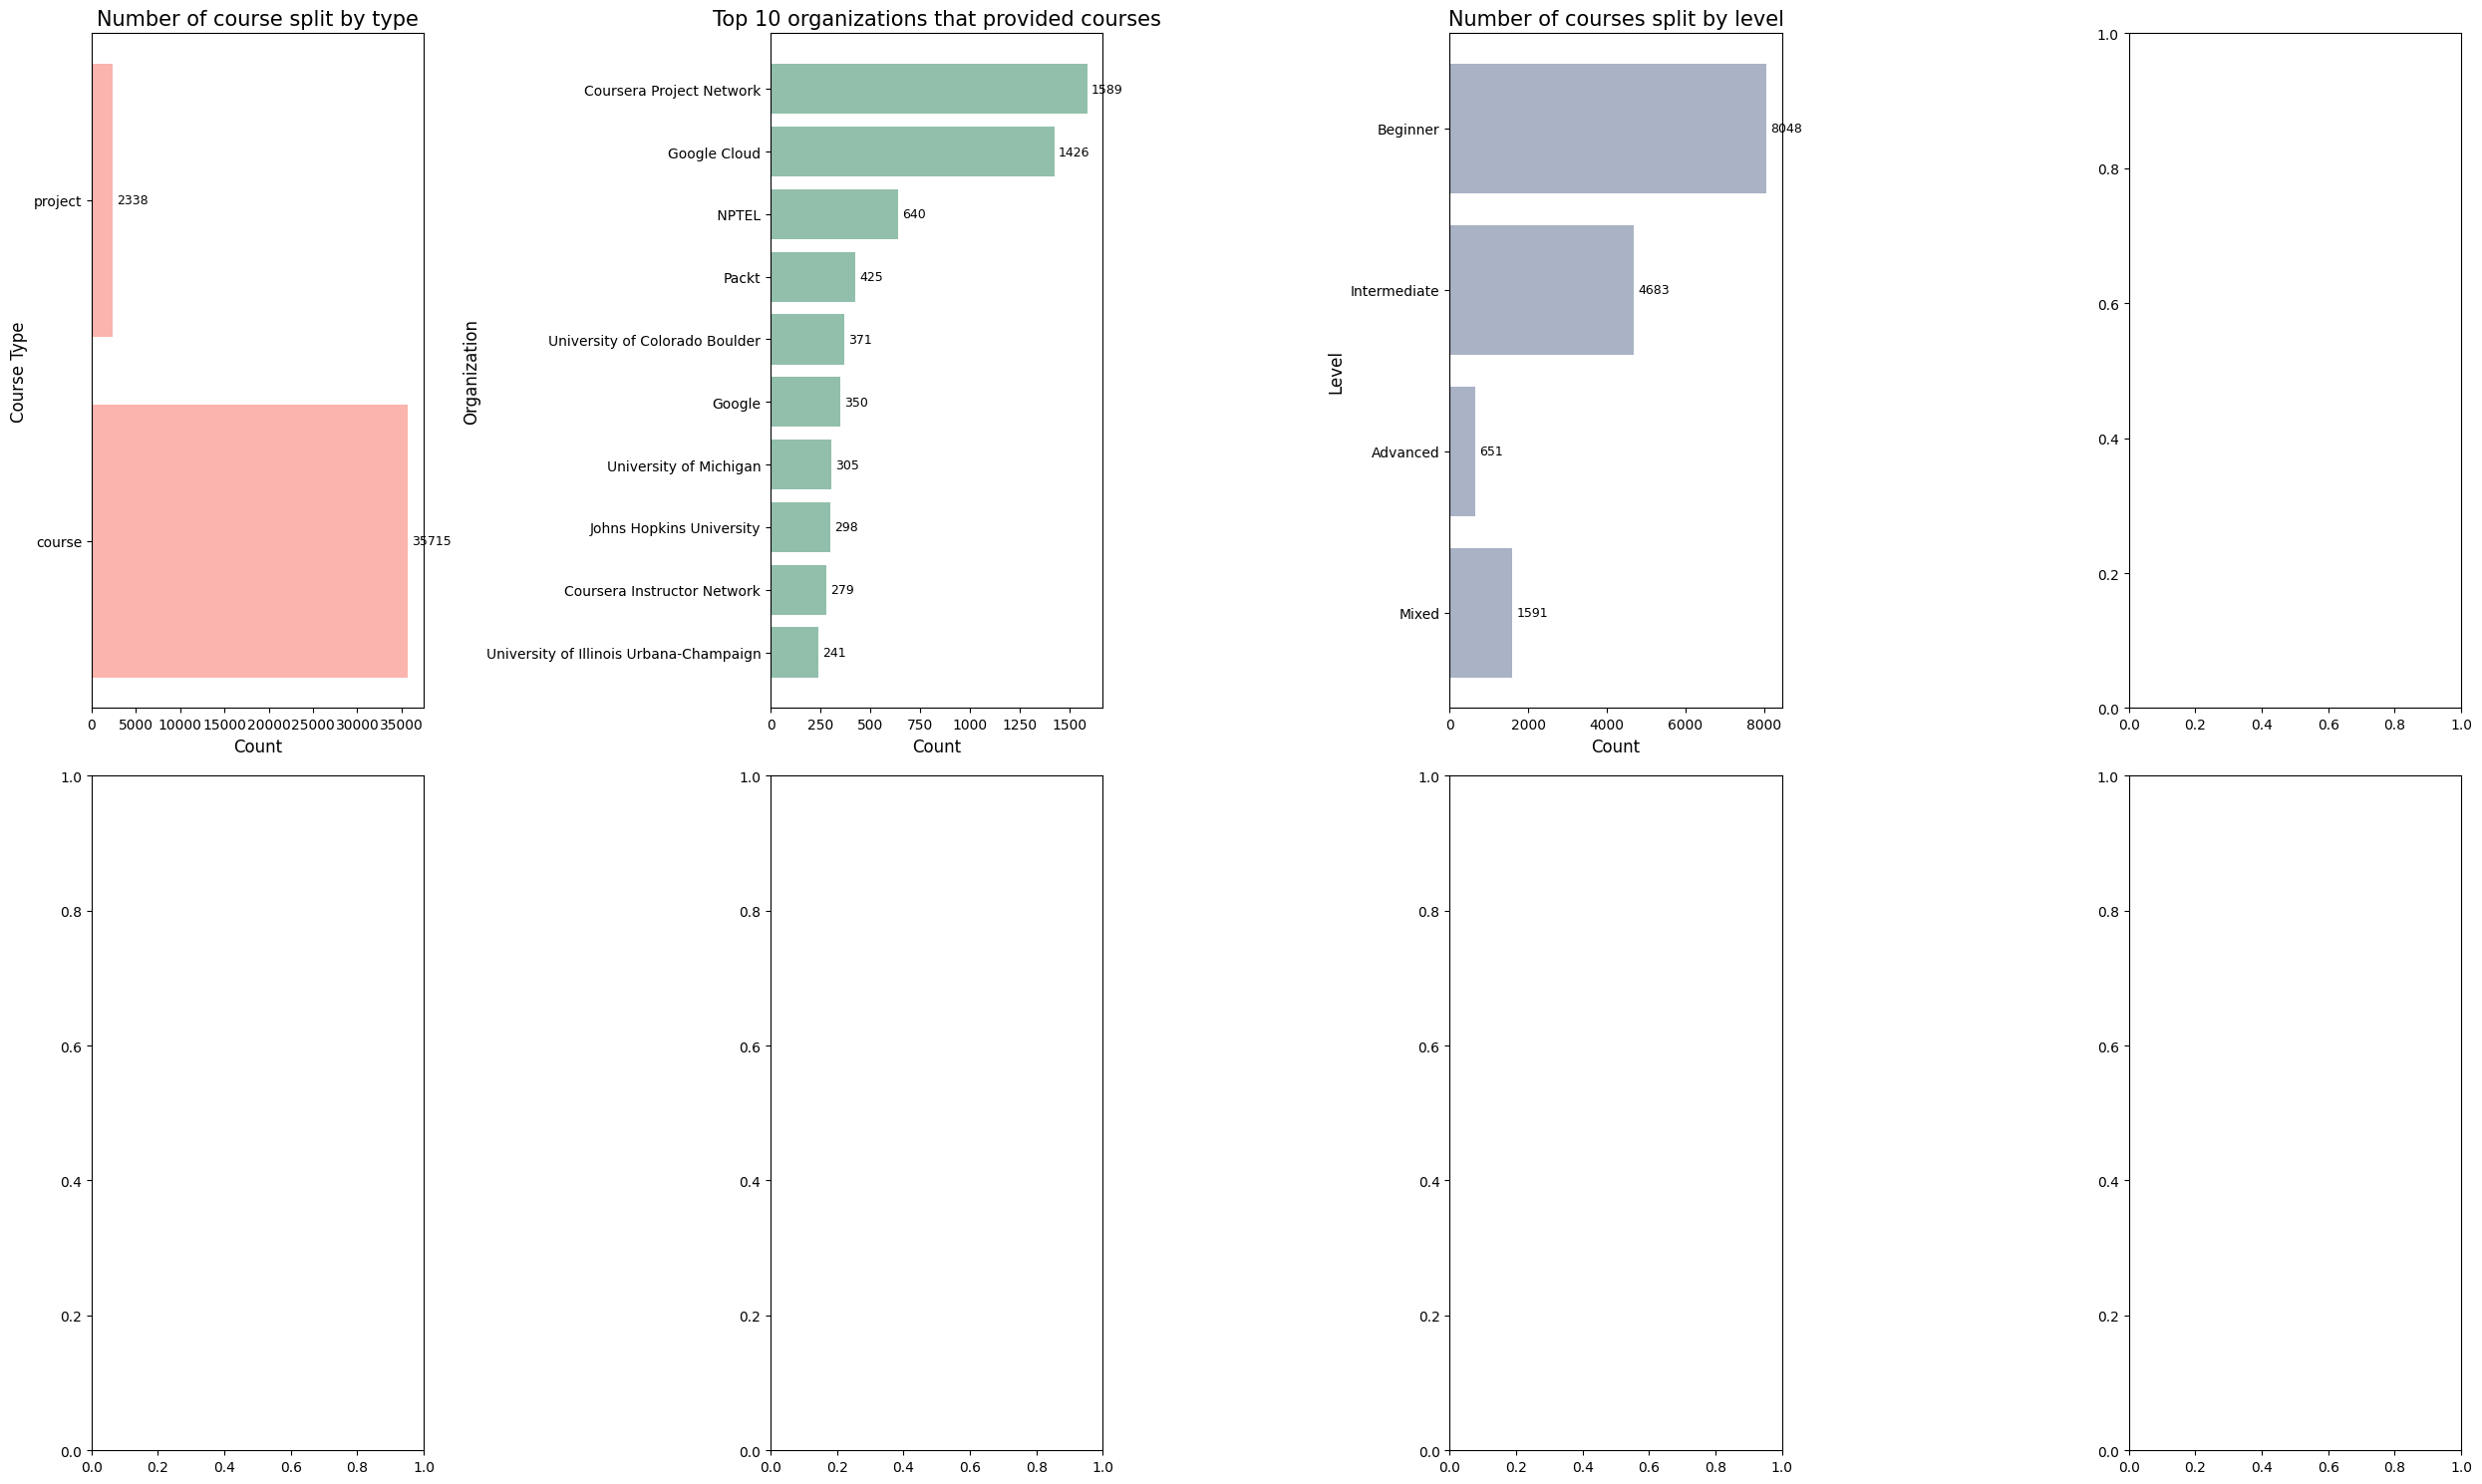

In [46]:
# Define global variables
mpl.rcParams['axes.prop_cycle'] = mpl.cycler(color=plt.cm.Pastel1.colors)
FS = 12

fig, ax = plt.subplots(nrows=2, ncols=4)
fig.set_figheight(15)
fig.set_figwidth(25)

# 1. Countplot of type column
bars = ax[0, 0].barh(count_type['type'], count_type['count'])
for bar in bars:
  width = bar.get_width()
  y = bar.get_y() + bar.get_height() / 2
  ax[0, 0].annotate(f'{width}', xy=(width, y), xytext=(3, 0), textcoords='offset points', va='center', fontsize=FS-3)
ax[0, 0].set_title("Number of course split by type", fontsize=FS+3)
ax[0, 0].set_ylabel("Course Type", fontsize=FS)
ax[0, 0].set_xlabel("Count", fontsize=FS)

# 2. Countplot of organisation column
bars = ax[0, 1].barh(top_10_organization['organization'], top_10_organization['count'], color="#92bfab")
for bar in bars:
  width = bar.get_width()
  y = bar.get_y() + bar.get_height() / 2
  ax[0, 1].annotate(f'{width}', xy=(width, y), xytext=(3, 0), textcoords='offset points', va='center', fontsize=FS-3)
ax[0, 1].set_title("Top 10 organizations that provided courses", fontsize=FS+3)
ax[0, 1].set_ylabel("Organization", fontsize=FS)
ax[0, 1].set_xlabel("Count", fontsize=FS)

# 3. Countplot of level column
bars = ax[0, 2].barh(count_level['level'], count_level['count'], color="#a9b3c5")
for bar in bars:
  width = bar.get_width()
  y = bar.get_y() + bar.get_height() / 2
  ax[0, 2].annotate(f'{width}', xy=(width, y), xytext=(3, 0), textcoords='offset points', va='center', fontsize=FS-3)
ax[0, 2].set_title("Number of courses split by level", fontsize=FS+3)
ax[0, 2].set_ylabel("Level", fontsize=FS)
ax[0, 2].set_xlabel("Count", fontsize=FS)

fig.tight_layout()